# Saliency Maps of ConvNext train to predict Covid-19 dataset

## 0. Load libraries and define functions

In [31]:
import os
import sys
import inspect
import pandas as pd
import torch
from PIL import Image
from models.image_classifier_module import ImageClassificationLightningModule
from torchmetrics import MetricCollection
from models.convnext import ConvNext, get_preprocess_transformation
from torch import nn
import configuration as config
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from PIL import Image
from torch import Tensor
from pandas import DataFrame
from torchvision.transforms import Compose

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir)


def count_classes(directory: str) -> int:
    """
    Get the list of unique labels in the given directory.

    Args:
        directory (str): The directory path.

    Returns:
        list: A list of unique labels found in the directory.
    """
    unique_labels = sum([1 for label in os.listdir(directory)])
    return unique_labels

### 0.1 To load model from checkpoint


We use pytorch lightning to load the model from the checkpoint.

In [32]:
def load_convnext_from_checkpoint() -> 'nn.Module':
    """
    Load a ConvNext model from a checkpoint.

    This function sets the matmul precision to high, determines the device to use,
    counts the number of classes, initializes the metrics, creates a ConvNext model,
    and then loads the model parameters from a checkpoint.

    Returns:
    nn.Module: The loaded ConvNext model.
    """
    torch.set_float32_matmul_precision("high")
    device = "cuda" if torch.cuda.is_available() else "cpu"

    class_count = count_classes(config.ROOT_DIR)
    metrics = MetricCollection({})
    vector_metrics = MetricCollection({})

    convnext = ConvNext(num_classes=class_count, device=device)
    model = ImageClassificationLightningModule.load_from_checkpoint(
        checkpoint_path=config.CONVNEXT_DIR
        + config.CONVNEXT_FILENAME
        + str(0)
        + ".ckpt",
        model=convnext,
        loss_fn=nn.CrossEntropyLoss(),
        metrics=metrics,
        vectorized_metrics=vector_metrics,
        lr=config.LR,
        scheduler_max_it=config.SCHEDULER_MAX_IT,
    ).model
    return model

### 0.2 Compute saliency maps


To compute the saliency maps we use the following code, essentially we compute the gradient of the output with respect to the input, and then we take the absolute value of the gradient. We finally display that tensor as an image and we use hot colormap to display the saliency map.

In [33]:
def compute_saliency_map(model: 'nn.Module', image_tensor: Tensor) -> Tensor:
    """
    Compute the saliency map for an image tensor using a model.

    Parameters:
    model (nn.Module): The model to use for computing the saliency map.
    image_tensor (Tensor): The image tensor to compute the saliency map for.

    Returns:
    Tensor: The computed saliency map.
    """
    model.eval()
    image_tensor.requires_grad_()
    scores = model(image_tensor)
    score_max_index = scores.argmax()
    score_max = scores[0, score_max_index]
    score_max.backward()
    saliency, _ = torch.max(image_tensor.grad.data.abs(), dim=1)
    return saliency

def plot_image_and_saliency(image: Image, saliency: Tensor, class_name: str, index: int) -> None:
    """
    Plot an image and its saliency map side by side.

    Parameters:
    image (Image): The image to plot.
    saliency (Tensor): The saliency map to plot.
    class_name (str): The class name for the title of the plot.
    index (int): The index for the title of the plot.
    """
    plt.figure(figsize=(10, 5))

    # Show the original image in the first subplot
    plt.subplot(1, 2, 1)
    plt.imshow(np.asarray(image))
    plt.title(f'Image {class_name}_{(index % 2)+1}')

    # Show the saliency map in the second subplot
    plt.subplot(1, 2, 2)
    plt.imshow(saliency[0].cpu(), cmap=plt.cm.hot)
    plt.title('And its Saliency Map')
    plt.show()

## 1. Display saliency maps of ConvNext model trained to predict Covid-19

We give the model 2 images per class, and we display the saliency maps of the model for those images. We can where the model is focusing to make the prediction.

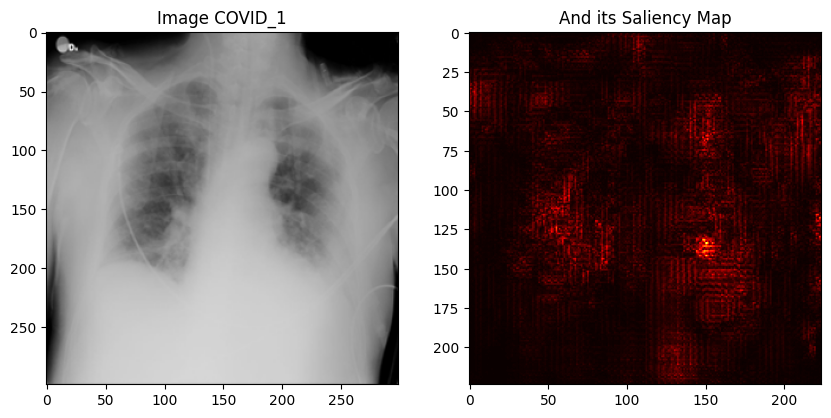

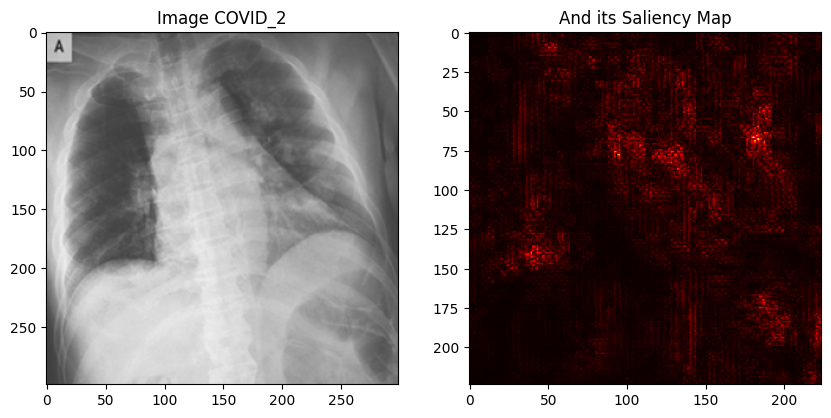

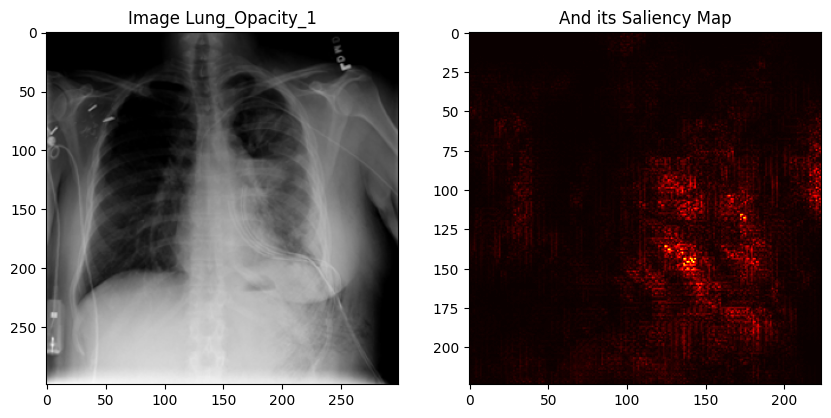

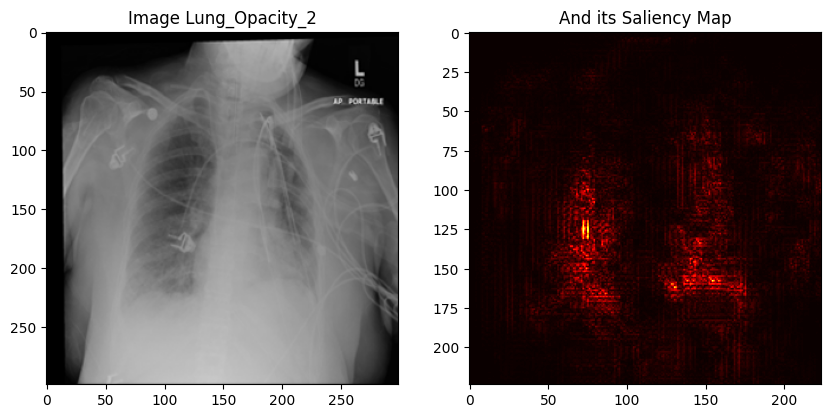

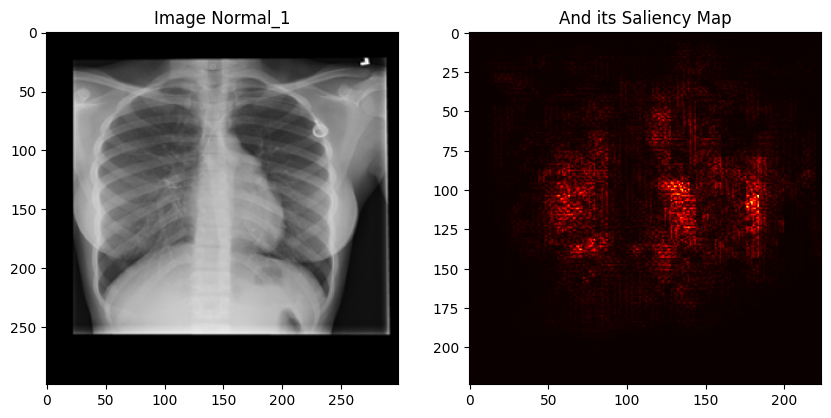

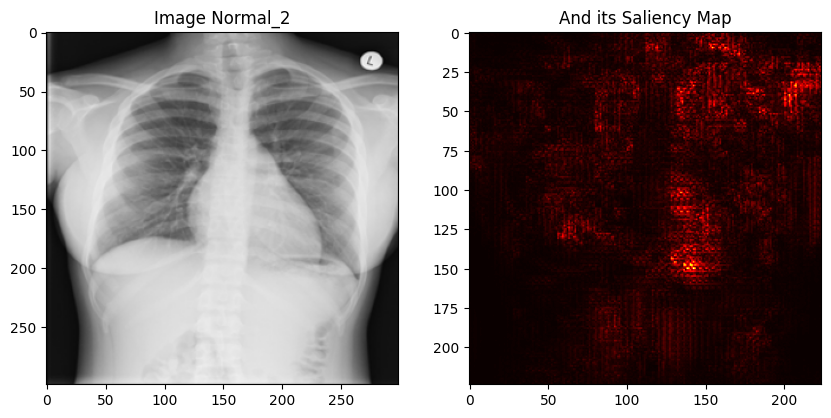

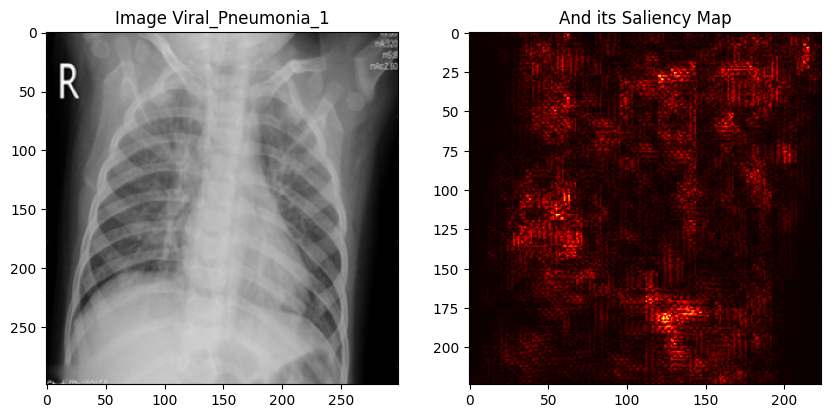

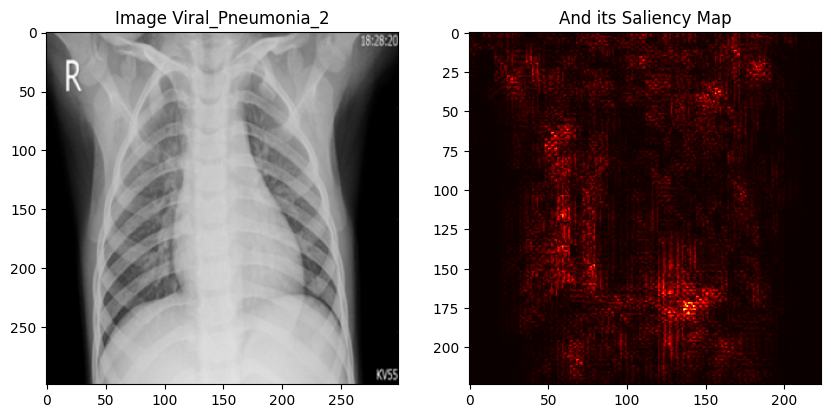

In [34]:
torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"

convnext = load_convnext_from_checkpoint()

preprocess = get_preprocess_transformation()
saliency_samples = pd.read_csv(
    "dataset/saliency_maps_samples/saliency_sample_filenames.csv", index_col=0
)
for index, row in saliency_samples.iterrows():
        image_filename = row["filename"]
        image = Image.open(image_filename).convert("RGB")
        X = preprocess(image).unsqueeze(0).to(device)
        saliency = compute_saliency_map(convnext, X)
        plot_image_and_saliency(image, saliency, row['class'], index)